### Import libraries

In [49]:
import random
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import v2
import seaborn as sns
from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

### Setup device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Load data

In [3]:
train_data = datasets.MNIST(
    root = ".",
    train = True,
    download = True,
    transform = v2.ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = ".",
    train = False,
    download = True,
    transform = v2.ToTensor()
)

c:\Users\48663\Desktop\Projects\Digit-recognition\venvmnist\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Plot random images

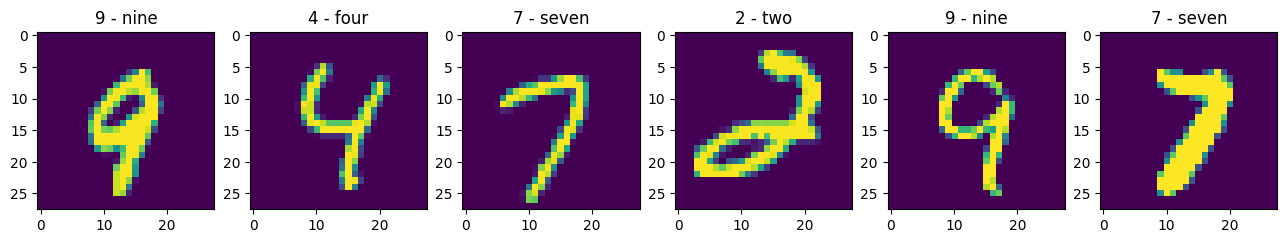

In [5]:
random.seed(42)
rnd_idx = random.sample(range(len(train_data)), k=6)
plt.figure(figsize=(16, 8))

for i, idx in enumerate(rnd_idx):
    
    plt.subplot(1, 6, i+1)
    img = train_data[idx][0].permute(1, 2, 0)
    label = train_data[idx][1]
    
    plt.title(class_names[label])
    plt.imshow(img)

### Prepare DataLoader

In [6]:
BATCH_SIZE=32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [7]:
one_batch_feat, one_batch_lab = next(iter(train_dataloader))
print(f"{one_batch_feat.shape} -> [Batch Size, Channels, Height, Width]")

torch.Size([32, 1, 28, 28]) -> [Batch Size, Channels, Height, Width]


### Build simple model

In [8]:
class ModelMnist1(nn.Module):
    def __init__(self, input_shape: int,  hidden_size: int, output_size: int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_size, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size*12*12, out_features=output_size)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.classifier(x)
        return x
        
torch.manual_seed(42)
model0 = ModelMnist1(1, 10, 10).to(device)
model0

ModelMnist1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1440, out_features=10, bias=True)
  )
)

### Build function for training and testing

In [9]:
def train_func(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    acc_fn,
    optimizer: torch.optim.Optimizer,
    device: torch.device    
):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_preds = model(X)
        
        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += acc_fn(y_preds, y)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    print(f"Train loss: {train_loss:.3f}, Train accuracy: {train_acc:.2f}")
    
    
def test_func(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    acc_fn,
    device: torch.device  
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataloader:
            
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += acc_fn(test_pred, y)
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.2f}")

### Model training

In [13]:
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)
acc = Accuracy(task="multiclass", num_classes=len(class_names))
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_func(model0, train_dataloader, loss_fn, acc, optimizer, device)
    test_func(model0, test_dataloader, loss_fn, acc, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.210, Train accuracy: 0.94
Test loss: 0.071, Test accuracy: 0.98


 33%|███▎      | 1/3 [01:30<03:00, 90.44s/it]

Epoch: 1
---------
Train loss: 0.077, Train accuracy: 0.98
Test loss: 0.060, Test accuracy: 0.98


 67%|██████▋   | 2/3 [02:53<01:25, 85.85s/it]

Epoch: 2
---------
Train loss: 0.059, Train accuracy: 0.98
Test loss: 0.057, Test accuracy: 0.98


100%|██████████| 3/3 [04:16<00:00, 85.43s/it]


### Evaluate model random predictions

In [30]:
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample shape: {test_samples[0].shape}, Test label: {test_labels[0]}")

Test sample shape: torch.Size([1, 28, 28]), Test label: 2


In [35]:
pred_probs = []
model0.eval()

with torch.inference_mode():
    for sample in test_samples:
        sample = torch.unsqueeze(sample, dim=0).to(device)
        
        pred_logit = model0(sample)
        
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        pred_probs.append(pred_prob)
pred_probs = torch.stack(pred_probs)
pred_probs

tensor([[3.4212e-08, 4.0491e-07, 9.9986e-01, 7.7896e-06, 4.2687e-15, 1.2491e-11,
         5.1106e-10, 1.8640e-08, 1.3623e-04, 2.0221e-08],
        [2.5495e-06, 9.5956e-01, 4.5556e-04, 3.4173e-04, 1.3024e-03, 5.9955e-03,
         6.0155e-03, 1.1887e-04, 2.3841e-02, 2.3627e-03],
        [9.7343e-05, 2.4604e-13, 9.9982e-01, 7.2521e-05, 5.7490e-12, 1.1524e-07,
         2.4900e-10, 8.4071e-08, 1.4116e-05, 8.5521e-07],
        [4.1146e-08, 8.1566e-07, 3.5917e-09, 1.2369e-05, 9.6559e-01, 2.5775e-06,
         2.1612e-07, 1.0083e-05, 6.8191e-06, 3.4375e-02],
        [6.1297e-06, 9.5137e-11, 3.8092e-09, 1.3107e-11, 7.2282e-07, 1.1499e-10,
         9.9999e-01, 4.6253e-10, 2.0560e-08, 3.2152e-09],
        [1.7544e-04, 6.6648e-09, 4.5413e-08, 4.4964e-09, 2.7896e-05, 1.6165e-10,
         9.9980e-01, 9.8402e-09, 1.9134e-07, 2.7796e-08],
        [2.9338e-11, 8.3386e-07, 2.8655e-08, 5.9324e-09, 9.9982e-01, 3.0843e-08,
         4.5461e-10, 3.4156e-06, 5.2133e-06, 1.7442e-04],
        [1.8811e-09, 2.5363

In [36]:
pred_class = pred_probs.argmax(dim=1)
pred_class

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

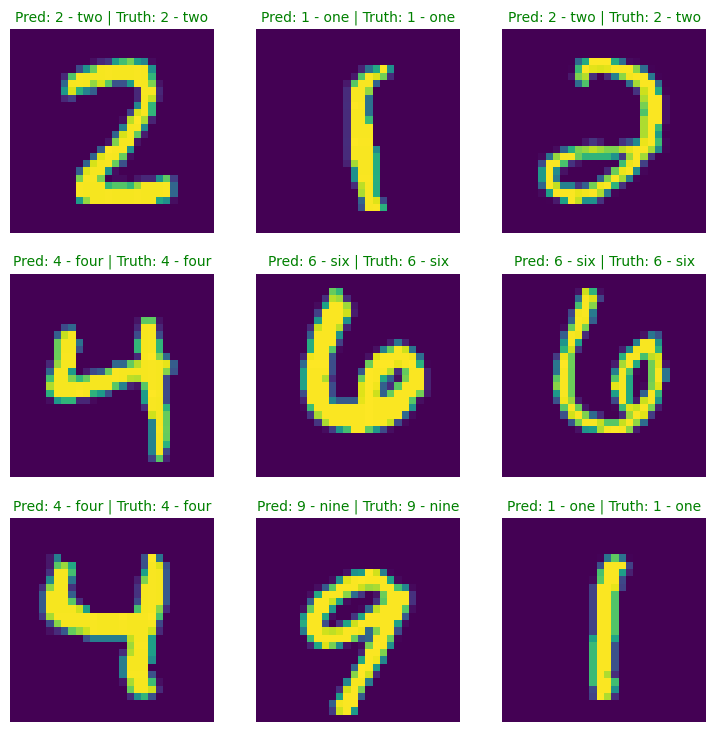

In [37]:
plt.figure(figsize=(9, 9))

for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i+1)
    
    plt.imshow(sample.squeeze())
    
    pred_label = class_names[pred_class[i]]
    
    true_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {true_label}"
    
    if pred_label == true_label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

### Evaluate model performance

In [39]:
y_preds = []
model0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = model0(X)
    
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:02<00:00, 125.54it/s]


In [41]:
confusion_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
prec = Precision(num_classes=len(class_names), task="multiclass")
recall = Recall(num_classes=len(class_names), task="multiclass")
f1score = F1Score(num_classes=len(class_names), task="multiclass")

In [46]:
confmat_tensor = confusion_mat(preds=y_pred_tensor,
                         target=test_data.targets)
prec_val = prec(preds=y_pred_tensor,
                         target=test_data.targets)
recall_val = recall(preds=y_pred_tensor,
                         target=test_data.targets)
f1score_val = f1score(preds=y_pred_tensor,
                         target=test_data.targets)
print(f"Precision: {prec_val*100:.2f}")
print(f"Recall: {recall_val*100:.2f}")
print(f"F1score: {f1score_val*100:.2f}")

Precision: 98.15
Recall: 98.15
F1score: 98.15


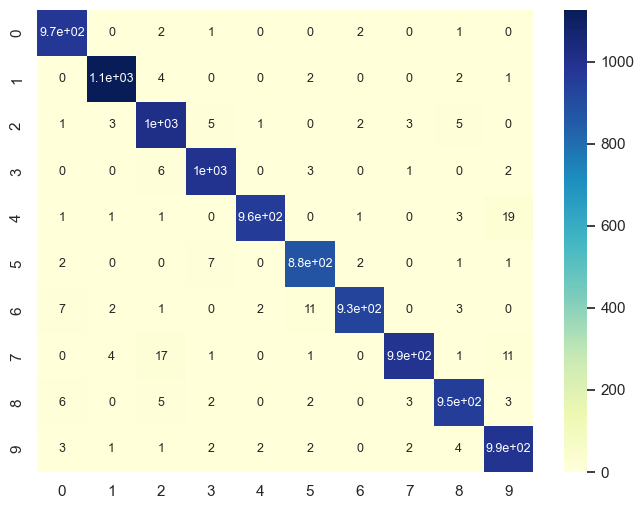

In [66]:
df_conf_mat = pd.DataFrame(confmat_tensor.numpy(), range(10), range(10))
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_mat, annot=True, annot_kws={"size": 9}, cmap="YlGnBu")
plt.show()